In [1]:
import xml.etree.ElementTree as ET
from collections import Counter, defaultdict
from copy import deepcopy
from glob import glob
from pathlib import Path
from tempfile import NamedTemporaryFile

import matplotlib.pyplot as plt
import numpy as np
from Bio import PDB, AlignIO
from Bio.PDB.Chain import Chain
from Bio.PDB.DSSP import DSSP
from Bio.PDB.Model import Model
from Bio.PDB.Structure import Structure
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
parser = PDB.MMCIFParser()

In [3]:
model_files = glob("../data/utp-data/structures/*/fold_*_model_0.cif")
structures = {
    Path(f)
    .stem.lstrip("fold_")
    .rstrip("_model_0"): parser.get_structure(
        Path(f).stem.lstrip("fold_").rstrip("_model_0"), f
    )
    for f in model_files
}

In [5]:
all_aligns = AlignIO.read("../data/ucyn-a_enriched/ucyn-a_enriched_cobalt_cleaned.fa", "fasta")
structure_ids = set(structures.keys())

c_term_start = 880
c_term_end = 1010

aligns = {}
for align in all_aligns:
    full_id = align.id
    _id = " ".join(align.description.split(" ")[1:]).replace("-", "_").lower()
    if _id not in structure_ids:
        continue
    align.id = _id
    align.description = ""
    aligns[_id] = align

In [6]:
c_term_structs = {}
for seqid, align in aligns.items():
    # translate the aligned c_term_start and c_term_end to unaligned residue indicies
    start_idx = len(align.seq[:c_term_start].replace("-", ""))
    struct = structures[seqid]
    c_term_residues = list(struct.get_residues())[start_idx:]
    new_structure = Structure(seqid + "_c_term")
    new_chain = Chain("A")
    new_model = Model(0)

    for residue in c_term_residues:
        new_chain.add(residue)

    new_model.add(new_chain)
    new_structure.add(new_model)
    c_term_structs[seqid] = new_structure

In [9]:
for seqid, align in aligns.items():
    # translate the aligned c_term_start and c_term_end to unaligned residue indicies
    start_idx = len(align.seq[:c_term_start].replace("-", ""))
    struct = structures[seqid]
    c_term_residues = list(struct.get_residues())[start_idx:]
    new_structure = Structure(seqid + "_c_term")
    new_chain = Chain("A")
    new_model = Model(0)


In [7]:
def parse_xml_motifs(file_path):
    meme_xml = ET.parse(file_path)
    return meme_xml


def extract_scanned_sites(meme_xml):
    sites = meme_xml.findall(".//scanned_sites")
    scanned_sites = [
        (tag.attrib["sequence_id"], site.attrib)
        for tag in sites
        for site in tag.findall("scanned_site")
    ]
    return scanned_sites


meme_xml = parse_xml_motifs("../data/utp-data/meme/meme_gb.xml")
scanned_sites = extract_scanned_sites(meme_xml)
sequences = defaultdict(list)
for seq, motif in scanned_sites:
    sequences[seq].append(motif)
sequences = {
    seq: sorted(motifs, key=lambda motif: int(motif["position"]))
    for seq, motifs in sequences.items()
}
motif_seqs = {
    tag.attrib["id"]: tag.attrib["name"] for tag in meme_xml.findall(".//motif")
}

seq_names = {
    tag.attrib["id"]: tag.attrib["name"] for tag in meme_xml.findall(".//sequence")
}
seq_motifs = {
    seq_name: sequences[seq_id]
    for seq_id, seq_name in seq_names.items()
    if seq_id in sequences
}
seq_motifs = {
    seq_name: sorted(motifs, key=lambda motif: int(motif["position"]))
    for seq_name, motifs in seq_motifs.items()
}
seq_motifs_with_pos = {
    seq_name: [(motif["motif_id"], int(motif["position"])) for motif in motifs]
    for seq_name, motifs in seq_motifs.items()
}
seq_motifs = {
    seq_name.replace("-", "_").lower(): "+".join([motif["motif_id"].split("_")[1] for motif in motifs])
    for seq_name, motifs in seq_motifs.items()
}

# motif_structures = defaultdict(list)
# for seqid, motifs in seq_motifs_with_pos.items():
#     full_id = align.id
#     _id = seqid.replace("-", "_").lower()
#     if _id not in c_term_structs:
#         continue
#     struct = c_term_structs[_id]
#     motifs_ids = "+".join([motif.split("_")[1] for motif, _ in motifs])
#     motif_pos = [pos for _, pos in motifs]
#     motif_structures[motifs_ids].append((struct, motif_pos))

In [ ]:
interesting_motifs = {"2+1+6+3+4", "2+1+3+4"}

secondary_structures = {}

for seqid, struct in c_term_structs.items():
    if seq_motifs.get(seqid, "") not in interesting_motifs:
        continue
    
    path = f"../data/utp-data/structures/c_term/{seqid}_c_term.pdb"
    io = PDB.PDBIO()
    io.set_structure(struct)
    io.save(path)
    
    # add CRYST1 record to the pdb file
    with open(path, "r") as f:
        lines = f.readlines()
    with open(path, "w") as f:
        for line in lines:
            if line.startswith("ATOM"):
                break
            f.write(line)
        f.write("CRYST1    1.000    1.000    1.000  90.00  90.00  90.00 P 1           1\n")
        for line in lines:
            f.write(line)
        

    model = struct[0]
    dssp = DSSP(model, path)
    sec_struct = [dssp[d][2] for d in dssp.keys()]
    secondary_structures[seqid] = sec_struct

In [ ]:
from Bio.PDB import Superimposer

rmsd_results = {}
c_term_structs_list = list((k, v) for k, v in c_term_structs.items() if seq_motifs.get(k, "") in interesting_motifs)

for idx1, (seqid1, structure1) in enumerate(c_term_structs_list):
    if seq_motifs.get(seqid1, "") not in interesting_motifs:
        continue
    for seqid2, structure2 in c_term_structs_list[idx1 + 1:]:
        if seq_motifs.get(seqid2, "") not in interesting_motifs:
            continue
        if seqid1 != seqid2:
            atoms1 = list(structure1.get_atoms())
            atoms2 = list(structure2.get_atoms())
            if len(atoms1) > len(atoms2):
                atoms1 = atoms1[:len(atoms2)]
            elif len(atoms2) > len(atoms1):
                atoms2 = atoms2[:len(atoms1)]
            superimposer = Superimposer()
            superimposer.set_atoms(
                atoms1,
                atoms2,
            )
            rmsd = superimposer.rms
            rmsd_results[(seqid1, seqid2)] = rmsd

## Clustering

In [ ]:
# Convert the RMSD results dictionary to a distance matrix
dist_matrix = np.zeros((len(rmsd_results), ))
for idx, rmsd in enumerate(rmsd_results.values()):
    dist_matrix[idx] = rmsd

In [ ]:
dist_matrix.min()

In [ ]:
# Perform hierarchical clustering
Z = linkage(dist_matrix, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=[s for s, _ in c_term_structs_list], leaf_rotation=90)
plt.xlabel('Sequence ID')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering of RMSD Results')
plt.show()

In [ ]:
labels=[s for s, _ in c_term_structs_list]
labels[int(np.random.choice(Z[:, 0]))]

In [ ]:
# compare structure of sequences with the same motif combianation and comapre with the generated sequences

In [3]:
# load aligned structures
model_files = glob("../data/utp-data/structures/c_term/aligned/*.cif")
structures = {
    Path(f)
    .stem.lstrip("fold_")
    .rstrip("_model_0"): parser.get_structure(
        Path(f).stem.lstrip("fold_").rstrip("_model_0"), f
    )
    for f in model_files
}
del structures['1']

Text(0, 0.5, 'Number of Residues within Radius')

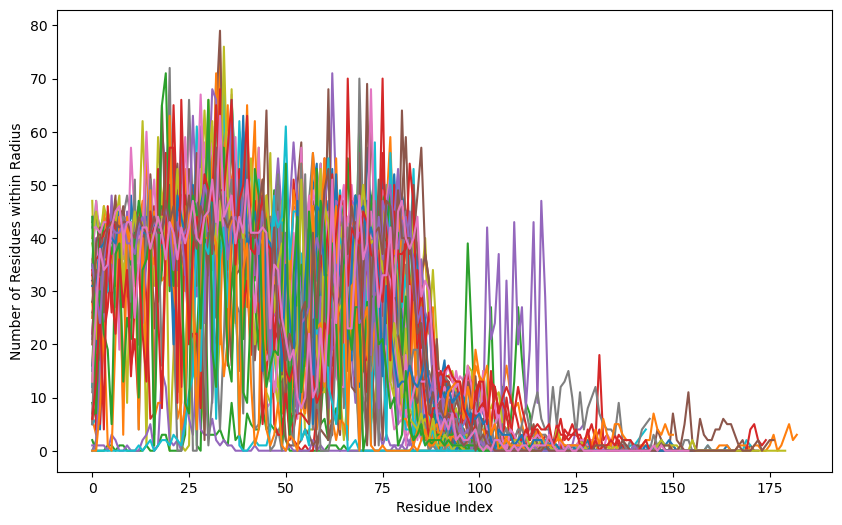

In [5]:
residue_positions = {
    seqid: np.stack([residue.center_of_mass() for residue in structures[seqid][0]["A"]]) for seqid in structures
}

RADIUS = 3
# for each residue in each structure, count the number of residues within a certain radius (of all structures)
# and plot the results
num_residues_within_radius = {}
for seqid, residues in residue_positions.items():
    num_residues = len(residues)
    num_residues_within_radius[seqid] = np.zeros(num_residues)
    for other_seqid, other_residues in residue_positions.items():
        if other_seqid == seqid:
            continue
        for idx, residue in enumerate(residues):
            num_residues_within_radius[seqid][idx] += np.sum(np.linalg.norm(other_residues - residue, axis=1) < RADIUS)

# compute

In [10]:
MIN_NUM_RESIDUES = 10

cropped_structures = {}
for seqid, residues_counts in num_residues_within_radius.items():
    # select region where the number of residues_counts within the radius is greater than MIN_NUM_RESIDUES
    roi_start, roi_end = None, None
    for idx, r in enumerate(residues_counts):
        if r > MIN_NUM_RESIDUES and roi_start is None:
            roi_start = idx
        elif r < MIN_NUM_RESIDUES and roi_start is not None:
            roi_end = idx
            break
    if roi_start is None:
        continue
    if roi_end is None:
        roi_end = len(residues_counts)
    
    struct = structures[seqid]
    roi_residues = list(struct[0]["A"])[roi_start:roi_end]
    new_structure = Structure(seqid + "_roi")
    new_chain = Chain("A")
    new_model = Model(0)
    
    for residue in roi_residues:
        new_chain.add(residue)
    
    new_model.add(new_chain)
    new_structure.add(new_model)
    cropped_structures[seqid] = new_structure

In [8]:
import colorsys

def generate_distinct_colors(n):
    colors = []
    for i in range(n):
        hue = i / n
        saturation = 0.5
        value = 0.8
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        hex_code = '#%02x%02x%02x' % (int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
        colors.append(hex_code)
    return colors

In [11]:
import py3Dmol
from io import StringIO
from Bio.PDB.PDBIO import PDBIO

v = py3Dmol.view(width=800, height=800)

colors = generate_distinct_colors(len(cropped_structures))
for idx, (seqid, struct) in enumerate(cropped_structures.items()):
    io = StringIO()
    pdb = PDBIO()
    pdb.set_structure(struct)
    pdb.save(io)
    pdb_str = io.getvalue()

    # v.setStyle({'cartoon': {'style':'cartoon'}})
    # v.addModel(pdb_str, "pdb", {"style": {"cartoon": {"color": colors[idx]}}})
# v

In [12]:
# create consensus structure
# 1. take the longest sequence
# 2. for each residue, in each sequence, find the corresponding residue in the longest sequence, if it is within RADIUS
# 3. calculate center of mass for each residue

longest_seqid = max(cropped_structures, key=lambda seqid: len(cropped_structures[seqid][0]["A"]))
longest_residues = list(cropped_structures[longest_seqid][0]["A"])

consensus_structure = PDB.Structure.Structure("consensus")
consensus_model = PDB.Model.Model(0)
consensus_chain = PDB.Chain.Chain("A")
consensus_model.add(consensus_chain)
consensus_structure.add(consensus_model)
consensus_stderrs = []
for residue in longest_residues:
    pos = residue.center_of_mass()
    closest_residues = []
    for seqid, struct in cropped_structures.items():
        if seqid == longest_seqid:
            continue
        positions = np.stack([res.center_of_mass() for res in struct[0]["A"]])
        distances = np.linalg.norm(positions - pos, axis=1)
        if np.min(distances) < RADIUS:
            closest_residues.append(list(struct[0]["A"].get_residues())[np.argmin(distances)])
    consensus_pos = np.mean([res.center_of_mass() for res in closest_residues], axis=0)
    stdev = np.std([res.center_of_mass() for res in closest_residues], axis=0)
    consensus_stderrs.append(stdev)
    majority_residue = Counter([r.get_resname() for r in closest_residues]).most_common(1)[0][0]
    residue_template = next((r for r in closest_residues if r.get_resname() == majority_residue)).copy()
    residue_template.detach_parent()
    trans_vector = consensus_pos - residue_template.center_of_mass()
    residue_template.transform(np.eye(3, 3), trans_vector)
    residue_template.id = residue.id
    residue_template.segid = residue.segid
    consensus_chain.add(residue_template)


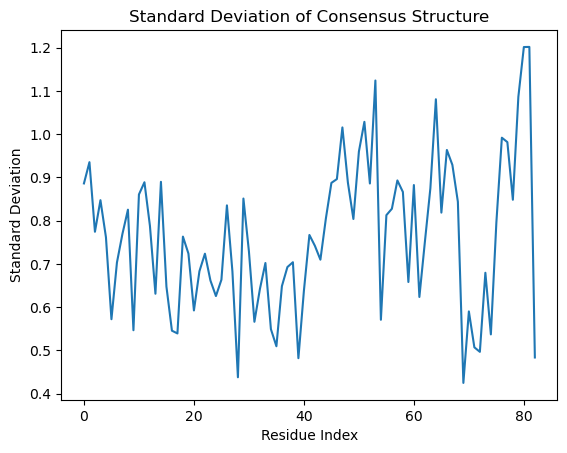

In [15]:
# plot the standard deviation of the consensus structure
stderrs = np.mean(consensus_stderrs, axis=1)
plt.plot(stderrs)
plt.xlabel("Residue Index")
plt.ylabel("Standard Deviation")
plt.title("Standard Deviation of Consensus Structure")
plt.show()

In [9]:

io = StringIO()
pdb = PDBIO()
pdb.set_structure(consensus_structure)
pdb.save(io)
pdb_str = io.getvalue()

v = py3Dmol.view(width=800, height=800)
v.addModel(pdb_str, "pdb", {"style": {"cartoon": {"color": "blue"}}})
# add spehere for each residue with radius proportional to the standard deviation
for idx, residue in enumerate(consensus_chain):
    pos = residue.center_of_mass()
    stderr = consensus_stderrs[idx]
    v.addSphere({"center": {"x": float(pos[0]), "y": float(pos[1]), "z": float(pos[2])}, "radius": float(np.linalg.norm(stderr)), "color": "red", "opacity": 0.8})
    
# save to file
with open("../data/utp-data/structures/c_term/aligned/consensus.pdb", "w") as f:
    f.write(pdb_str)
